In [2]:
###-----------------
### Import Libraries
###-----------------
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


import tensorflow as tf



In [3]:
###----------------
# Global Variables
###----------------


TEST_SIZE = 0.2
RANDOM_STATE = 0
np.random.seed(RANDOM_STATE)


N_SAMPLES = 1000
NOISE = 0.2
ALPHA = 0.1
EPOCHS = 1000

# set location of input files and output files
inpDir = '../input'
outDir = '../output'


# Set plotting parameters
params = {
    'figure.figsize': (15,4),
    'axes.titlesize': 'large',
    'axes.labelsize': 'medium',
    'legend.fontsize': 'medium',
    'xtick.labelsize': 'medium',
    'ytick.labelsize': 'medium',
}
plt.rcParams.update(params)


CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid')

In [4]:
###-----------------------------------------------------------
### Function to plot Loss Curve using Tensorflow history object
###------------------------------------------------------------

def fn_plot_tf_hist(hist_df):
    
    '''
    Args:
        hist_df: a dataframe with following ccolumns
            column 0: accuracy
            column 1: loss
            column 2: val_accuracy
            column 3: val_loss
            While plotting columns are accessed by index 
            so that even if the column names are different it will not throw exceptions.
    '''
        
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    CMAP = plt.cm.coolwarm
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y4] == hist_df[y4].min()]
    
    ax = axes[0]

    hist_df.plot(y = [y2,y4], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = '{:s}: \n  train: {:6.4f}\n   test: {:6.4f}'
    txtstr = txtFmt.format(y2.capitalize(), 
                           hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot
    
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)
    
    # calculate offset for arroe
    y_min = min(hist_df[y2].min(), hist_df[y4].min())
    y_max = max(hist_df[y2].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0
    
    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y4].to_numpy()[0] + offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3)

    ax.set_xlabel('Epochs')
    ax.set_ylabel(y2.capitalize())
    ax.set_title('Errors')
    ax.grid(True)
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y1, y3], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = '{:s}: \n  train: {:6.4f}\n  test:  {:6.4f}'
    txtstr = txtFmt.format(y1.capitalize(),
                           hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y3].min())
    y_max = max(hist_df[y1].max(), hist_df[y3].max())
    offset = (y_max-y_min)/10.0

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y3].to_numpy()[0]-offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3)

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.grid(True)
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()
    


---
$$
\textbf{Make Moon Dataset}
$$

In [5]:
X, y = datasets.make_moons(
    n_samples=N_SAMPLES,
    noise=NOISE, 
    random_state=RANDOM_STATE, 
    shuffle=True
)

X.shape, y.shape


((1000, 2), (1000,))

In [6]:
df = pd.DataFrame(X, columns=["X_1", "X_2"])
df["target"] = y
df.head()

,X_1,X_2,target
0,2.086144,0.574014,1
1,1.804609,0.006960,1
2,-0.227112,0.573910,0
3,-0.251226,0.187682,1
4,0.425744,-0.414247,1


<Figure size 1500x400 with 0 Axes>

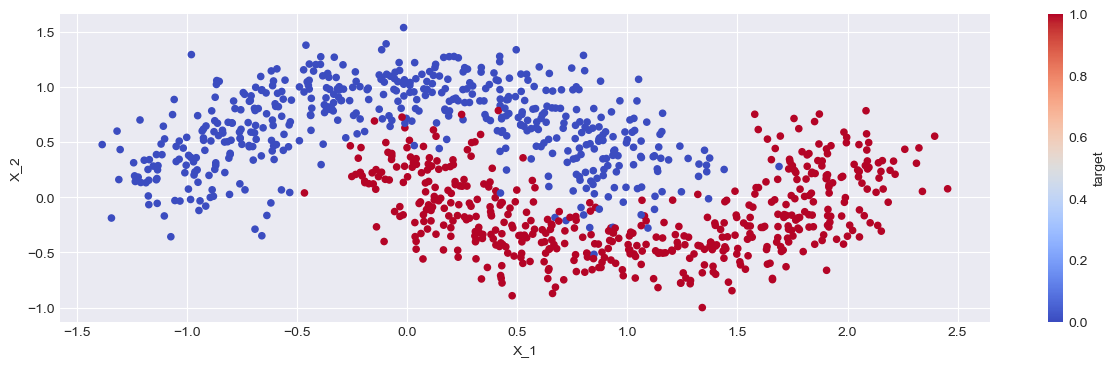

In [7]:
plt.figure()
df.plot.scatter(x="X_1", y="X_2", c="target", cmap=CMAP)
plt.show() 

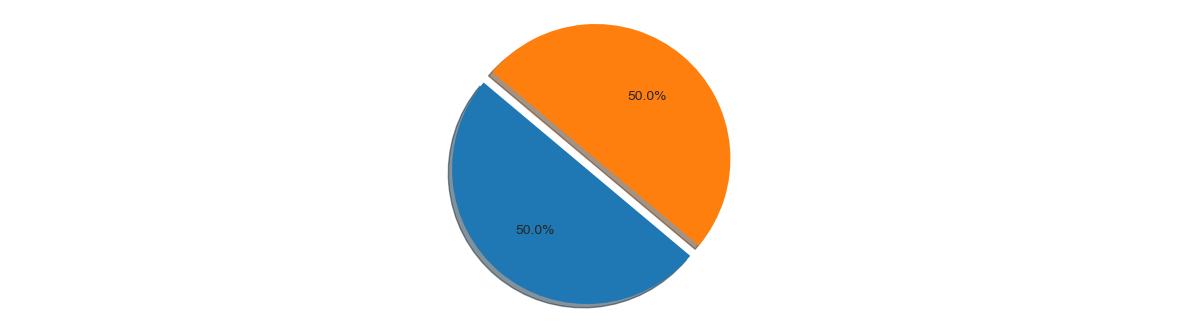

In [8]:
fix, axis = plt.subplots()
explode = (0, 0.1,) # only "explode" the 2nd ring
axis.pie(
    df['target'].value_counts(), 
    explode=explode, 
    autopct='%1.1f%%', 
    shadow=True, 
    startangle=140
)
axis.axis('equal') 
plt.show()

In [9]:
features_df = df.drop('target', axis=1)
labels_df = df['target'].to_numpy()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    features_df,
    labels_df,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=labels_df
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 2), (200, 2), (800,), (200,))

In [ ]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(2,)),
    tf.keras.layers.Dense(5, activation='relu', name='fc_1'),
    tf.keras.layers.Dense(5, activation='relu', name='fc_2'),
    tf.keras.layers.Dense(4, activation='relu', name='fc_3'),
    tf.keras.layers.Dense(3, activation='relu', name='fc_4'),
    tf.keras.layers.Dense(2)
])

In [14]:
predictions = model(X_train[:1]).numpy()
print(predictions.sum())


0.010885577


In [18]:
tf.nn.softmax(predictions).numpy().sum(axis=1)

array([1.], dtype=float32)

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 5)              │            15 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            15 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │             8 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92 (368.00 B)

 Trainable params: 92 (368.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model = build_model(layer_params, X_train, y_train)


tf.keras.utils.plot_model(model, 'firest-tf.png')

